# Synopsis

This Jupyter Notebook demonstrates the SDTM Dataset Specialization, a part of the CDISC Biomedical Concept (BC). The relationships between SDTM variables are part of the metadata, which can be sorted and retrieved using the CDISC Library API. Through a small game of guessing the relationship, we aim to show how this information can be used and visualized effectively.

Install CDISC Library client from PyPI, plus other dependencies in case you do not have them in your Python version environment.

In [ ]:
%pip install cdisc_library_client
%pip install pandas
%pip install numpy
%pip install networkx
%pip install matplotlib

In [1]:
import os
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt

from cdisc_library_client import CDISCLibraryClient

To set a permenent environment variable in user scope using PowerShell: `[System.Environment]::SetEnvironmentVariable("MY_VAR", "HelloWorld", "User")`

In [2]:
api_key = os.environ.get("CDISC_LIBRARY_API_KEY")
client = CDISCLibraryClient(api_key=api_key)

In [3]:
cosmos_api_version = "v2"
all_dss = client.get_sdtm_latest_sdtm_datasetspecializations(cosmos_api_version)

In [4]:
common_predicates = [
    "DECODES", "DESCRIBES", "GROUPS",
    "GROUPS_BY", "IDENTIFIES", "IDENTIFIES_OBSERVATION",
    "IS_ATTRIBUTE_FOR", "IS_DECODED_BY", "IS_DERIVED_FROM",
    "IS_GROUPED_BY", "IS_INDICATOR_FOR", "IS_ORIGINAL_TEXT_FOR",
    "IS_POSITION_FOR", "IS_RESULT_OF", "IS_SPECIMEN_TESTED_IN",
    "IS_SUBJECT_STATE_FOR", "IS_TIMING_FOR", "IS_UNIT_FOR",
    "PERFORMS", "SPECIFIES"
]

In [5]:
def get_dss_and_choices(client, all_dss, cosmos_api_version, common_predicates):
	"""
	Selects a random dataset specialization (DSS) and generates a set of relationships
	as triples (subject-predicate-object) for its variables. Randomly removes one predicate
	from the triples and provides a set of choices including the removed predicate.

	Args:
		client (CDISCLibraryClient): The CDISC Library client.
		all_dss (list): List of all dataset specializations.
		cosmos_api_version (str): The COSMoS API version to use.
		common_predicates (list): List of common predicates.

	Returns:
		tuple:
			- triples (list): List of triples with one predicate removed.
			- relationship_index (int): The index of the removed predicate.
			- choices (list): List of choices including the removed predicate.
			- answer (str): The removed predicate, i.e., the answer.
	"""
	while True:
		selected_dss = random.choice(all_dss)
		dss_name = selected_dss["href"].split("/")[-1]
		dss = client.get_sdtm_latest_sdtm_datasetspecialization(cosmos_api_version, dss_name)

		triples = [
			{
				"subject": variable["relationship"]["subject"],
				"predicate": variable["relationship"]["predicateTerm"],
				"object": variable["relationship"]["object"]
			}
			for variable in dss["variables"] if "relationship" in variable
		]

		if all(triple["predicate"] for triple in triples) and 3 < len(triples) <= 7:
			break

	relationship_index = random.randint(2, len(triples) - 1)

	answer = triples[relationship_index]['predicate']
	triples[relationship_index]['predicate'] = ''

	choices = random.sample(
		[predicate for predicate in common_predicates if predicate != answer], 2)
	choices.append(answer)
	random.shuffle(choices)

	return triples, relationship_index, choices, answer

In [6]:
def plot_relationship(triples):
	"""
	Plots the relationships as a directed graph.

	Args:
		triples (list): List of triples where each triple is a dictionary
		with 'subject', 'predicate', and 'object' keys.

	Returns:
		None
	"""
	g = nx.DiGraph()
	g.add_edges_from([(triple['subject'], triple['object'], {'label': triple['predicate']}) for triple in triples])

	pos = nx.shell_layout(g)
	nx.draw_networkx_nodes(g, pos, node_size=500)
	nx.draw_networkx_edges(g, pos, edgelist=g.edges())
	nx.draw_networkx_labels(g, pos)
	edge_labels = nx.get_edge_attributes(g, 'label')
	nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)
	plt.show()

Run the cell below to repeat the game.

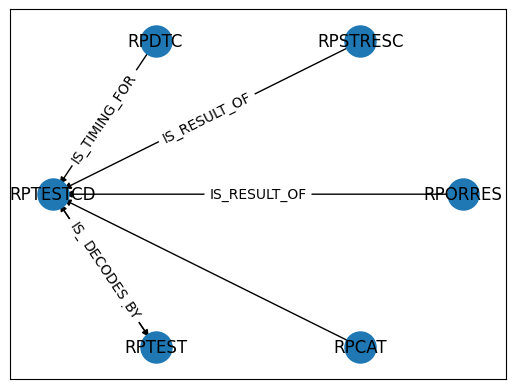

Which of the following is the missing predicate for the SDTM specialization shown?
RPCAT __________ RPTESTCD
1. IS_POSITION_FOR
2. IS_DERIVED_FROM
3. GROUPS

Congratulations.
The answer is: GROUPS


In [7]:
dss_game, i, choices, answer = get_dss_and_choices(client, all_dss, cosmos_api_version, common_predicates)
plot_relationship(dss_game)

print("Which of the following is the missing predicate for the SDTM specialization shown?")
print(f"{dss_game[i]['subject']} __________ {dss_game[i]['object']}")
print("1. " + choices[0])
print("2. " + choices[1])
print("3. " + choices[2])

user_input = input("Enter your choice (1, 2, or 3): ")

print("")
if choices[int(user_input) - 1] == answer:
	print("Congratulations.")
else:
	print(f"Sorry.")
print(f"The answer is: {answer}")